In [2]:
import pandas as pd, numpy as np
import matplotlib.pyplot as plt
from sklearn import linear_model 
from sklearn.metrics import mean_squared_error as mse_metric
from statsmodels.graphics.tsaplots import plot_acf

In [3]:
data_directory = '../data/experiment_verysmall/'
data = np.load(data_directory + 'network_params/data_network.npy')
data = np.transpose(data, (1, 2, 0))
data.shape

(2, 2801, 2)

In [4]:
data_train = data[:,:-3*365,:]
data_val = data[:,-3*365:-365,:]
data_test = data[:,-365:,:]

In [5]:
data_train_diff = np.diff(data_train, axis = 1)
data_val_diff= np.diff(data_val, axis = 1)
data_test_diff = np.diff(data_test, axis = 1)

### util

In [6]:
def get_mse(forecast, true_vals):
    N, f , _ = forecast.shape
    forecast = forecast.reshape(N, f * 2)
    true_vals = true_vals.reshape(N, f * 2)
    
    return mse_metric(forecast, true_vals)

def data_slice(data, h, f):
    T = h + f
    samples = np.array([data[:,t:t + T,:] for t in range(len(data[0]) - T + 1)])
    return samples[:, :, :h, :], samples[:, : , h:, :]

### Zero order hold forecaster

In [7]:
def get_ZOH_forecast(history, f=1):
    forecast = np.tile(history[:, -1:, :], (1, f, 1))
    return forecast

def get_ZOH_forecast_rmse(hists, futures):
    _,_,f,_ = futures.shape
    forecasts = np.array([get_ZOH_forecast(hist, f=f) for hist in hists])
    mse = np.mean([get_mse(forecasts[i], futures[i]) for i in range(len(futures))])
    return np.sqrt(mse)

In [8]:
h, f = 1, 7
hist_val, future_val = data_slice(data_val, h = h, f = f)
print(get_ZOH_forecast_rmse(hist_val, future_val))

6.103939246309808


### hist mean forecast

In [9]:
def get_histmean_forecast(history, f = 1):
    hist_diff = np.diff(history, axis = 1)
    mean_diff = np.mean(hist_diff, axis = 1, keepdims = True)
    tile = history[:,-1]
    slices = np.tile(np.arange(1,f+1), (len(history),1))
    slices = np.array([slices, slices]).transpose(1,2,0)
    add = np.tile(mean_diff,(1,f,1))*slices
    forecast =  np.repeat(tile[:, np.newaxis, :],f, axis=1) + add
    return forecast

def get_histmean_forecast_rmse(hists, futures):
    _,_,f,_ = futures.shape
    forecasts = np.array([get_histmean_forecast(hist, f=f) for hist in hists])
    mse = np.mean([get_mse(forecasts[i], futures[i]) for i in range(len(futures))])
    return np.sqrt(mse)


def histmean_hyperparam_search(data_train, data_val, h_range, f=3):
    val_rmses = []
    for h in h_range:
        hist_val, future_val = data_slice(data_val, h = h, f = f)
        val_rmses += [get_histmean_forecast_rmse(hist_val, future_val)]
    return val_rmses

In [10]:
f = 7
h_vals = np.arange(2,50)
hist_val, future_val = data_slice(data_val, h = h, f = f)
rmses = histmean_hyperparam_search(data_train, data_val, h_vals, f=f)

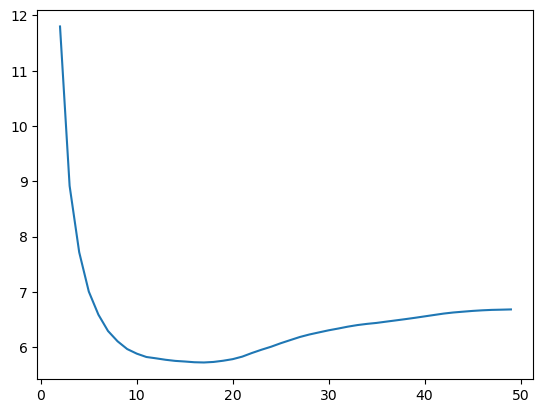

In [11]:
plt.plot(h_vals, rmses)

In [12]:
np.min(rmses)

5.721378919654803